In [12]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [19]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [20]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [21]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Перший шар, який складається з 128 нейронів
    self.layer1 = DenseLayer(num_features, n_hidden_1, name="layer1")
    # Другий шар, який складається з 256 нейронів
    self.layer2 = DenseLayer(n_hidden_1, n_hidden_2, name="layer2")
    # Вихідний шар
    self.out_layer = DenseLayer(n_hidden_2, num_classes, name="out_layer")


  def __call__(self, x):
    # Передача даних через перші два шари та вихідний шар з функцією активації softmax
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.out_layer(x, activation=1)


    return x

In [22]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    # Порівняння міток класів
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    # Обчислення точності
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [23]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
  # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активація автоматичного диференціювання
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Отримаємо список оптимізованих параметрів
    trainable_variables = neural_net.trainable_variables
    # Обчислимо за ними значення градієнта
    gradients = g.gradient(loss, trainable_variables)

    # Модифікуємо параметри
    optimizer.apply_gradients(zip(gradients, trainable_variables))


In [24]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        loss = cross_entropy(pred, batch_y)
        acc = accuracy(pred, batch_y)
        loss_history.append(loss)
        accuracy_history.append(acc)
        print(f"Step {step}, loss: {loss}, accuracy: {acc}")

Step 100, loss: 282.57098388671875, accuracy: 0.6640625
Step 200, loss: 260.6849060058594, accuracy: 0.7109375
Step 300, loss: 183.97244262695312, accuracy: 0.8125
Step 400, loss: 141.4664306640625, accuracy: 0.8125
Step 500, loss: 97.38873291015625, accuracy: 0.85546875
Step 600, loss: 160.30360412597656, accuracy: 0.84765625
Step 700, loss: 140.97418212890625, accuracy: 0.84375
Step 800, loss: 105.40203857421875, accuracy: 0.88671875
Step 900, loss: 119.63047790527344, accuracy: 0.86328125
Step 1000, loss: 82.09989929199219, accuracy: 0.91796875
Step 1100, loss: 106.25546264648438, accuracy: 0.87109375
Step 1200, loss: 88.7196044921875, accuracy: 0.88671875
Step 1300, loss: 64.53364562988281, accuracy: 0.91015625
Step 1400, loss: 73.15730285644531, accuracy: 0.90625
Step 1500, loss: 56.430702209472656, accuracy: 0.921875
Step 1600, loss: 102.19229125976562, accuracy: 0.8828125
Step 1700, loss: 93.14891815185547, accuracy: 0.90625
Step 1800, loss: 74.48751831054688, accuracy: 0.925781

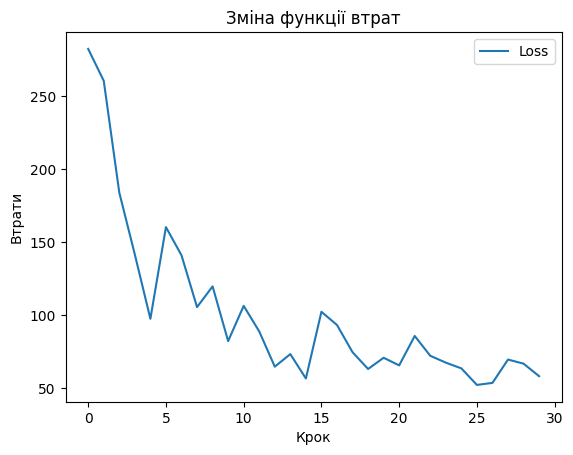

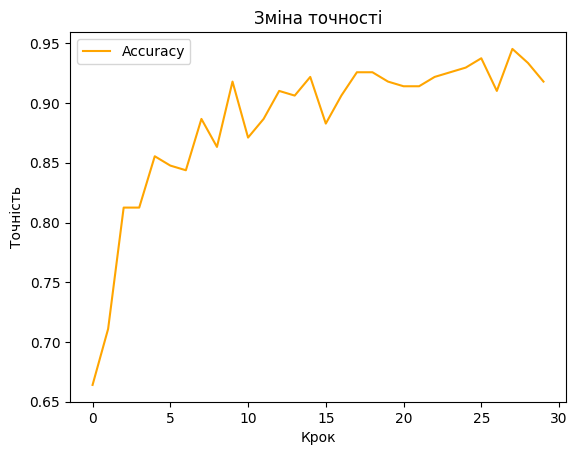

In [25]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

# Виведіть графік функції втрат
plt.plot(loss_history, label='Loss')
plt.title('Зміна функції втрат')
plt.xlabel('Крок')
plt.ylabel('Втрати')
plt.legend()
plt.show()

# Виведіть графік точності
plt.plot(accuracy_history, label='Accuracy', color='orange')
plt.title('Зміна точності')
plt.xlabel('Крок')
plt.ylabel('Точність')
plt.legend()
plt.show()

In [26]:
# Обчисліть точність навченої нейромережі
def compute_accuracy(neural_net, test_x, test_y):
    pred = neural_net(test_x)
    correct_predictions = tf.equal(tf.argmax(pred, 1), tf.cast(test_y, tf.int64))
    return tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

accuracy = compute_accuracy(neural_net, x_test, y_test)
print("Точність навченої нейромережі:", accuracy.numpy())

# Тестування моделі на тестових даних
test_accuracy = compute_accuracy(neural_net, x_test, y_test)
print("Точність на тестових даних:", test_accuracy.numpy())

Точність навченої нейромережі: 0.8999
Точність на тестових даних: 0.8999


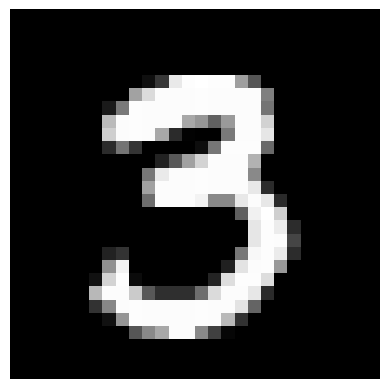

Передбачення нейронної мережі: 3


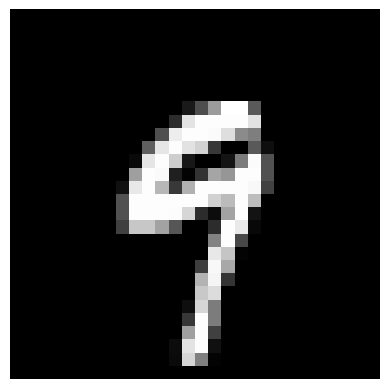

Передбачення нейронної мережі: 9


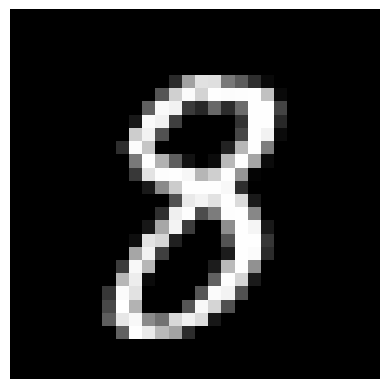

Передбачення нейронної мережі: 8


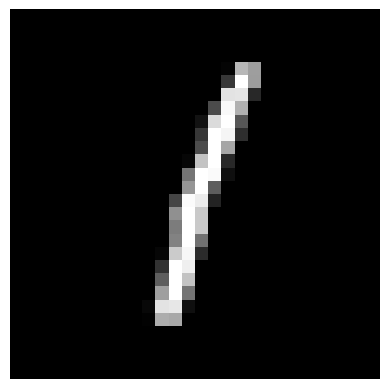

Передбачення нейронної мережі: 1


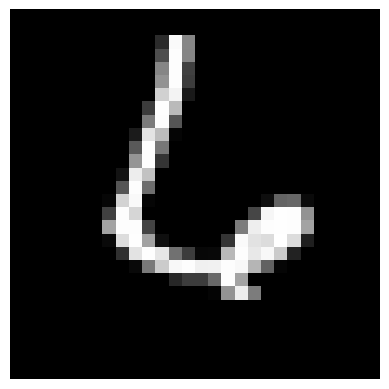

Передбачення нейронної мережі: 6


In [27]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть  поруч відповідь нейромережі.
# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

import random

# Випадковим чином вибираємо 5 індексів зображень з тестового набору даних
random_indices = random.sample(range(len(x_test)), 5)

# Прогнозування класів для вибраних зображень
predictions = neural_net(x_test[random_indices])

# Виведення зображень та передбачень
for i, idx in enumerate(random_indices):
    image = x_test[idx].reshape((28, 28))
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()
    print("Передбачення нейронної мережі:", tf.argmax(predictions[i]).numpy())




In [28]:
from sklearn.metrics import classification_report

# Отримуємо передбачення для тестових даних
y_pred = neural_net(x_test)

# Перетворюємо передбачення у масив індексів класів
y_pred_classes = tf.argmax(y_pred, axis=1)

# Виведення метрик якості для кожного класу
print(classification_report(y_test, y_pred_classes))


              precision    recall  f1-score   support

           0       0.94      0.95      0.95       980
           1       0.98      0.97      0.97      1135
           2       0.91      0.88      0.89      1032
           3       0.85      0.89      0.87      1010
           4       0.89      0.90      0.90       982
           5       0.85      0.87      0.86       892
           6       0.93      0.91      0.92       958
           7       0.88      0.92      0.90      1028
           8       0.86      0.86      0.86       974
           9       0.90      0.83      0.87      1009

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

